<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/>

# NIRSpec MOS data reprocessing with the JWST pipeline

Updated February 2024 running JWST pipeline version 1.13.4 with CRDS context jwst_1193.pmap

processing 

## Table of Contents

* [Overview](#overview)
* [Observations](#observations)
* [JWST Pipeline](#pipeline)
* [Related Notebooks](#related)
* [Import Libraries](#import)
* [Download the data](#data)
* [Stage1: `Detector1Pipeline`](#stage1)
* [Stage2: `Spec2Pipeline`](#stage2)
* [Stage3: `Spec3Pipeline`](#stage3)
* [Change 1D extraction rows: `Extract1dStep`](#extract1d)

# Wish List

* distinguish confirmation images vs. science in MAST (current hack is to download smaller files with fewer groups)
* automatic way to determine file to download from CRDS: 'jwst_nirspec_extract1d_0003.json'
* why is that one quadrant so high in the one rate file?

# Overview <a id='overview'></a>

Data from JWST observations are processed by the JWST pipeline and made available in MAST.
Outputs from any stage of the pipeline may be retrieved and reprocessed if desired.

There are some 
[known issues with NIRSpec MOS data products](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/known-issues-with-jwst-data-products)
and with the 
[JWST pipeline run on NIRSpec MOS data](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats)
using default settings.

When rerunning the pipeline on this NIRSpec MOS data, we make two key adjustments to input parameters:
* outlier rejection of cosmic rays and snowballs: `Detector1Pipeline` jump step 
* extraction rows for 1D spectrum (`x1d`) from 2D spectrum (`s2d`): `extract1d` [`ystart` – `ystop`]

## Observations <a id='observations'></a>

[ERO 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=2736) NIRSpec MOS observations:

* two identical observations: 7, 8
* (Confirmation images after TA: 20 groups NRSIRS2RAPID = 306 s)
* G235M & G395M
* 3 slitlet nods x 2 integrations x 20 groups NRSIRS2 = 8841 s exposure time = 2.5 hours (in each grating and observation)

### Galaxies of interest
* **6355** z = 7.665 (13.0 Gyr ago)  
    * We'll look at this one in this notebook
    * excellent spectrum with bright lines
    * 5 slitlets in a row (rather than standard 5), so 1D extraction can be improved significantly
    * not a multiple image of 10612 below at similar redshift
* 5144 z = 6.383
  
[featured in the press release](https://webbtelescope.org/contents/news-releases/2022/news-2022-035):
*  4590 z = 8.498 (13.1 Gyr ago)  
* 10612 z = 7.663 (13.0 Gyr ago)  
*  8140 z = 5.275 (12.6 Gyr ago)  
*  9922 z = 2.743 (11.3 Gyr ago)  

and presented and studied in papers including 
[Katz et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..592K), 
[Curti et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..425C), 
[Carnall et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518L..45C)


# JWST Science Calibration Pipeline <a id='pipeline'></a>
**JWST Pipeline**
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst) •
`pip install jwst`

Below we summarize the various pipeline stages and data products.

[**Data Products**](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html)
(also see [JDox](https://jwst-docs.stsci.edu/getting-started-with-jwst-data/understanding-jwst-data-files/jwst-data-products))  

`uncal` (counts) –> `rate` (slopes) –> `cal` (extracted calibrated 2D spectra) –> `s2d` (rectified 2D spectra) –> `x1d` (1D spectra)

[Retrieve data from MAST](https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search)
(also see [ReadtheDocs](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html))

`uncal` uncalibrated data saved from every detector readout

[**JWST Pipeline Stages**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing)
(also see [ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/main.html))

[**Stage 1**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1):
[calwebb_detector1](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)
[`Detector1Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Detector1Pipeline.html)

Detector corrections for flat field, artifacts, etc., followed by ramp fitting to slopes (count rates)  
`rate` count rate (slope) averaged over multiple integrations, if available  
`rateints` count rates for each individual integration (saved in multiple extensions)

[**Stage 2**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2):
[calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)
[`Spec2Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Spec2Pipeline.html)

Extracted calibrated spectra for each source from each exposure (or association) and each detector, including any corrections for slit loss, path loss, and bar shadows.
Slits or exposures defined as background will have negative spectra.
Each source will be an extension in the file:  
`cal` / `calints` calibrated 2D (unrectified) spectra (flux vs. wavelength)  
`crf` / `crfints` cosmic ray flagged data, identical to `cal` products with updated DQ arrays  
`s2d` 2D spectra resampled (rectified) to a rectangle  
`x1d` 1D spectra extracted from rows of 2D spectrum

[**Stage 3**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3):
[calwebb_spec3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)
[`Spec3Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Spec3Pipeline.html)

Extracted calibrated spectra for each source:  
`cal` / `calints` identical to Stage 2 outputs, repackaged for each source (multiple extensions for each exposure and detector)  
`crf` / `crfints` cosmic ray flagged data, identical to `cal` products with updated DQ arrays  
spectra combined from multiple exposures, including background subtraction:
`s2d` 2D spectra resampled (rectified) to a rectangle  
`x1d` 1D spectra extracted from rows of 2D spectrum

Note these filenames will have the same extensions (`cal`, `s2d`, `x1d`, etc.) but have different structures depending on which stage they are output from:
* Stage 2: one file from each exposure (or association) and detector; one extension for each source
* Stage 3: one file for each source; `cal`: one extension for each exposure (or association) and detector

# Related Notebooks <a id='related'></a>


* [NIRSpec MOS pipeline caveats](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats)
and workaround notebooks for 
[general NIRSpec](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
data and
[NIRSpec MOS](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_MOS)
* Notebooks running pipeline on [NIRSpec fixed slit data](coming soon) and
[BOTS data](https://github.com/exonik/JWebbinar2023-TSO)
* Notebooks running pipeline on simulated NIRSpec MOS data:
[JWebbinar7 (Oct 2021)](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb) •
[JDAT (2021)](https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb) •
[JADES (June 2022)](https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb)
* [Notebook processing ERO SMACS0723 NIRSpec MOS data](https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb)
using the JWST pipeline and 
[msaexp](https://github.com/gbrammer/msaexp)
* [MOSViz notebook analyzing NIRSpec MOS spectra](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [JDAT: JWST Data Analysis Example Notebooks](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks)

### JWST file naming conventions

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [3]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

import crds
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

/Users/dcoe/crds_cache
Current Operational CRDS Context = jwst_1193.pmap


In [4]:
# Import JWST pipeline 

import jwst
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
import json

# JWST version won't be right if development version (may say 1.12.3 when it's really 1.12.6)
print("JWST Calibration Pipeline Version={}".format(jwst.__version__)) 

JWST Calibration Pipeline Version=1.13.4


In [5]:
from IPython.display import JSON  # nicer interactive output of JSON dictionaries

In [6]:
# To run faster on multiple cores in parallel
import multiprocessing as mp 
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [7]:
# To retrieve data from MAST

import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [8]:
# To view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [9]:
# Define colormap
cmap = 'viridis'
#bad_color = 1, 0.7, 0.7
bad_color = 'r'  # color used for nan values
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

In [35]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

# Set up data directories

In [10]:
download_dir = 'data'  # download from MAST
os.makedirs(download_dir, exist_ok=True)

In [27]:
rate_dir = 'com_mos_rate_files'  # Charles Proffitt  /grp/jwst/wit4/nirspec/proffitt/msa_fflat_sprint_files/com_mos_rate_files/

In [11]:
output_dir = 'reprocess'  # results from rerunning pipeline
os.makedirs(output_dir, exist_ok=True)

In [12]:
run_pipeline = True  # if False, already ran the pipeline; just load the results

# Download UNCAL files: Query and retrieve from MAST archive <a id='data'></a> 

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data  

https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html  

https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search

https://mast.stsci.edu/api/v0/_productsfields.html

In [13]:
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists
            # However, it will delete it if it's there and the wrong size (e.g., reprocessed)
            Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [14]:
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

In [15]:
#Observations.get_metadata("products")  # list all possible keyword filters

In [16]:
obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                        proposal_id = 1128,
                                        instrument_name = 'NIRSPEC/MSA',
                                        #filters = 'g395m',
                                        dataproduct_type = 'spectrum',
                                       )

products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.

In [19]:
data_products = Observations.filter_products(
    products_list, 
    productType = 'SCIENCE', 
    productSubGroupDescription = 'S2D',  # UNCAL, RATE[INTS], CAL[INTS], S2D, X1D, ASN
    type = 'S', # 'S': simple output from spec2 / image2;  'D': combined multiple exposures from spec3
)  
#data_products  # table of files retrieved from MAST

In [22]:
s2d_files = sorted(unique(data_products, keys='productFilename')['productFilename'])
s2d_files

['jw01128018001_03102_00002_nrs1_s2d.fits',
 'jw01128018001_03102_00003_nrs1_s2d.fits',
 'jw01128018001_03102_00004_nrs1_s2d.fits',
 'jw01128019001_03102_00002_nrs1_s2d.fits',
 'jw01128019001_03102_00002_nrs2_s2d.fits',
 'jw01128019001_03104_00001_nrs1_s2d.fits',
 'jw01128019001_03104_00001_nrs2_s2d.fits',
 'jw01128019001_03106_00001_nrs1_s2d.fits',
 'jw01128019001_03106_00001_nrs2_s2d.fits',
 'jw01128019001_03108_00001_nrs1_s2d.fits',
 'jw01128019001_0310a_00001_nrs1_s2d.fits',
 'jw01128019001_0310c_00001_nrs1_s2d.fits',
 'jw01128019001_0310e_00001_nrs1_s2d.fits',
 'jw01128019001_0310g_00001_nrs1_s2d.fits',
 'jw01128019001_0310i_00001_nrs1_s2d.fits']

In [24]:
#download_dir = 'data'
s2d_files = download_jwst_files(s2d_files, download_dir)

In [ ]:

data_products = Observations.filter_products(products_list, 
                                            productType = 'SCIENCE', 
                                            productSubGroupDescription = 'UNCAL',  # UNCAL, RATE[INTS], CAL[INTS], I2D, S2D, X1D, ASN
                                            )  



In [ ]:
uncal_files = glob(os.path.join(download_dir, '*_uncal.fits'))  # find files already downloaded

# Download files from MAST if you haven't already
# Could also let this run to check for all files. But the MAST query takes a minute.
if len(uncal_files) == 0:
    obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                            proposal_id = 2736,  # program number 2736: ERO SMACS0723
                                            instrument_name = 'NIRSPEC/MSA',
                                            filters = 'g395m',
                                            dataproduct_type = 'spectrum',
                                           )
    
    products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.
    
    data_products = Observations.filter_products(products_list, 
                                                productType = 'SCIENCE', 
                                                productSubGroupDescription = 'UNCAL',  # UNCAL, RATE[INTS], CAL[INTS], I2D, S2D, X1D, ASN
                                                )  

    #data_products  # list files retrieved from MAST
    
    # Only keep science files with full data; not smaller files (confirmation images with fewer groups)
    file_sizes = unique(data_products, keys='size')['size']
    print(file_sizes)
    big_files = data_products[data_products['size'] > np.mean(file_sizes)]
    #uncal_files = unique(data_products, keys='productFilename')['productFilename']
    uncal_files = unique(big_files, keys='productFilename')['productFilename']
    uncal_files = download_jwst_files(uncal_files, download_dir)

In [ ]:
uncal_files

# Show rate file

-0.054591674357652664 0.12853480130434036
jw01128018001_03102_00002_nrs1_rate.fits


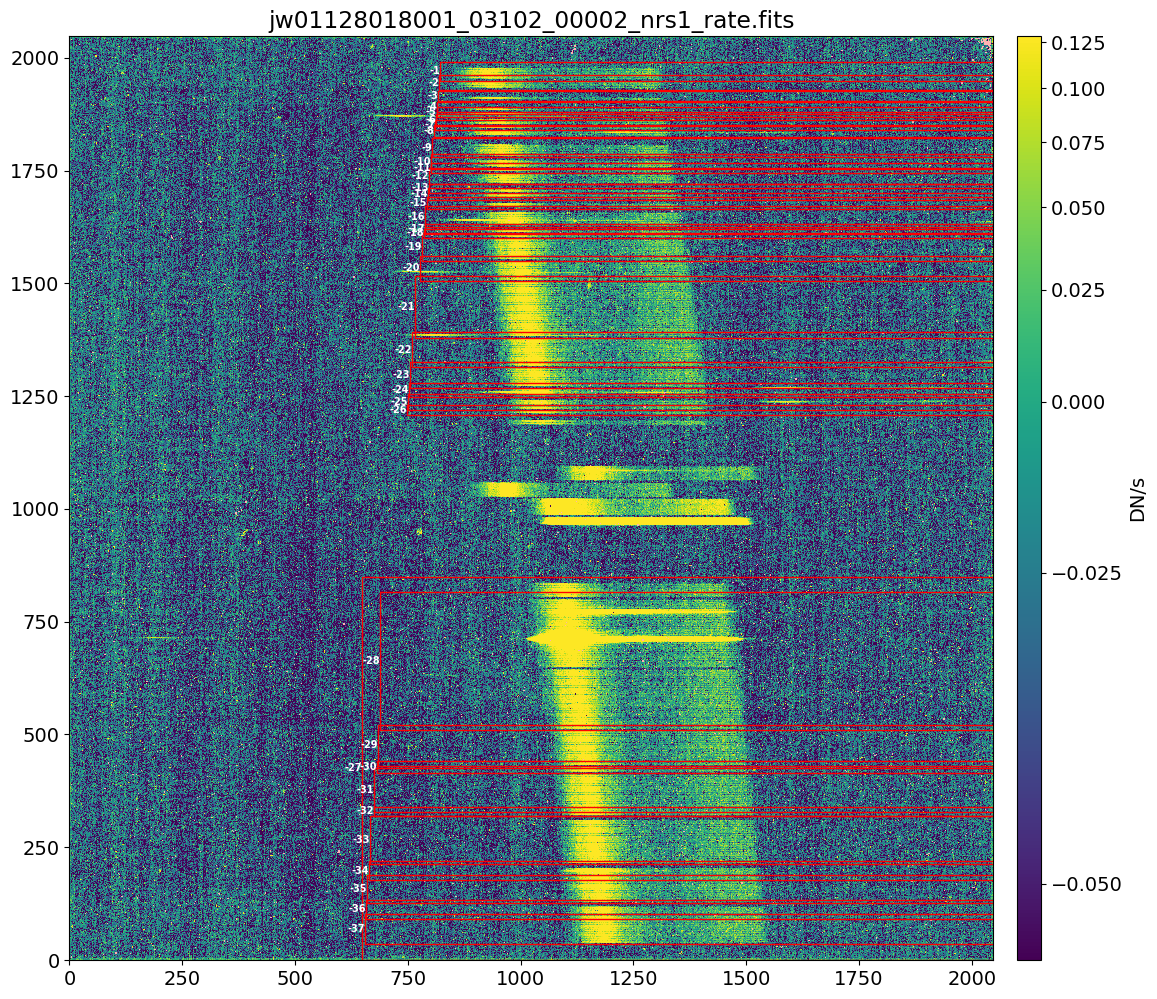

In [39]:
def show_MOS_rate(rate_file, slits_model, save_plot=False, close_plot=False, integration=None, 
                  cmap='viridis', bad_color=(1,0.7,0.7), vmin=-0.003, vmax=0.022,
                  source_id=None, title_start=None, title_path=False):
    # slits_model can be either s2d or cal from spec2 -- contains slit models for all the sources
    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    #ax.imshow(data, origin='lower', vmin=-0.004, vmax=0.022, interpolation='nearest')

    #norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    #norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    print(norm.vmin, norm.vmax)
    
    #im  = ax.imshow(data, origin='lower', cmap='viridis', norm=norm, interpolation='none')

    if source_id:
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = slits_model.slits[i_slit]
        #slit_model = s2d_model.slits[i_slit]
        #rate_stamp = data[slit_model.ystart:slit_model.ystart+slit.ysize, slit_model.xstart:slit_model.xstart+slit.xsize]

        left   = slit_model.xstart
        right  = slit_model.xsize + left
        bottom = slit_model.ystart
        top    = slit_model.ysize + bottom
        extent = left, right, bottom, top
        print(extent)
        
        rate_stamp = data[bottom:top, left:right]
        im  = ax.imshow(rate_stamp, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='nearest', aspect=5)
        print(source_id, slit_model.xstart, slit_model.ystart, rate_stamp.shape, slit_model.data.shape)
        
    else:        

        im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    
    
        if 0:
            path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]  # add white outline to text below
            fontsize = 12
            color = 'r'
        else:
            path_effects = []  # no outline
            fontsize = 7
            color = 'w'
        
        slit_patches = []
        for slit in slits_model.slits:
            slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
            slit_patches.append(slit_patch)
            y = slit.ystart + slit.ysize/2
            va = 'center'
            if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
                x = slit.xstart
                ha = 'right'
            else: # Label the spectra on the right hand side for NRS2: 
                x = slit.xstart + slit.xsize
                ha = 'left'
            plt.text(x, y, slit.source_id, color=color, ha=ha, va=va, fontsize=fontsize, path_effects=path_effects, weight='bold')
        
        ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

    if title_start:
        title = title_start + '  '
    else:
        title = ''

    if title_path:
        title += rate_file
    else:
        title += os.path.basename(rate_file)
    
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    if source_id:
        title += '  source %d' % source_id
    
    plt.title(title)
    print(title)

    #plt.tight_layout()

    plt.subplots_adjust(left=0.05, right=0.85)

    units = 'DN/s'
    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    cbar_dx = 0.02
    cbar_ax = fig.add_axes([ax.get_position().x1+cbar_dx, ax.get_position().y0, cbar_dx, ax.get_position().height])
    #cbar_ax = fig.add_axes([ax.get_position().x1-cbar_dx, ax.get_position().y0, cbar_dx, ax.get_position().height])
    cbar = fig.colorbar(im, label=units, cax=cbar_ax)
    if 0:
        cbar_ticks = cbar_ax.get_yticks()
        cbar_ticks = np.concatenate([cbar_ticks, [norm.vmin, norm.vmax]])
        cbar_ticks = np.compress(between(vmin, cbar_ticks, norm.vmax), cbar_ticks)
        cbar_ticks = np.sort(cbar_ticks)
        cbar.set_ticks(cbar_ticks)
        print(cbar_ticks)

    #plt.tight_layout()

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

#show_MOS_rate(rate_file1, cal_model_spec2_nrs1, save_plot=True)
show_MOS_rate(rate_file, s2d_model_spec2_nrs1, save_plot=True)

In [ ]:
for rate_file in rate_files:
    show_MOS_rate(rate_file, s2d_model_spec2_nrs1, save_plot=True)

In [79]:
def show_MOS_rate_files(rate_files, slit_models=[], save_plot=False, close_plot=False, integration=None):
    fig, axs = plt.subplots(1, len(rate_files), figsize=(15,8), sharey=True)
    plt.subplots_adjust(wspace=0.02)

    for ifile, rate_file in enumerate(rate_files):        
        if not os.path.exists(rate_file):
            continue
            
        with fits.open(rate_file) as hdu_list:
            data = hdu_list['SCI'].data
            if integration == 'min':
                data = data.min(axis=0)
            elif integration != None:
                data = data[integration]

        ax = axs[ifile]
        #norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
        #norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=LinearStretch())
        #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
        norm = simple_norm(data, 'linear', min_percent=20, max_percent=98)
        print(norm.vmin, norm.vmax)
        # Turn off interpolation! Or else bad pixels will appear to grow in the plot
        im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

        if len(slit_models):
            # Labels 2D extraction regions on MSA detector rate image
            slit_model = slit_models[ifile]
            slit_patches = []
            path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]
            fontsize = 8
            for slit in slit_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                #plt.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='w', va='center', fontsize=12, weight='bold')
                #print('nrs1' in rate_file)
                if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
                    ax.text(slit.xstart, slit.ystart + slit.ysize/2, slit.source_id, color='r', ha='right', va='center', fontsize=fontsize, path_effects=path_effects)
                else:  # 'nrs2' # Label the spectra on the right hand side for NRS2:
                    ax.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='r', va='center', fontsize=fontsize, path_effects=path_effects)
            
            ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))
        
        title = os.path.basename(rate_file)
        if integration != None:
            title = title.replace('rateints', 'rateints[%s]' % integration)
    
        ax.set_title(title)
        print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if len(rate_files):
                save_plot = save_plot.replace('_nrs1', '')
                save_plot = save_plot.replace('_nrs2', '')                
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        print('SAVING', save_plot)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

for rate_file_nrs1 in rate_files_019_nrs1:
    rate_file_nrs2 = rate_file_nrs1.replace('nrs1', 'nrs2')
    show_MOS_rate_files([rate_file_nrs1, rate_file_nrs2], save_plot=True, close_plot=True)
    #show_MOS_rate_files([rate_file_nrs1, rate_file_nrs2], [s2d_model_spec2_nrs1, s2d_model_spec2_nrs2], save_plot=True, close_plot=True)    

-0.01874157078564167 0.007505330033600314
jw01128019001_03102_00002_nrs1_rate.fits
-0.023642634600400926 0.010093849785625919
jw01128019001_03102_00002_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00002_rate.png
-0.00628170371055603 0.019558446854352967
jw01128019001_03102_00003_nrs1_rate.fits
-0.006271139811724423 0.02508800797164437
jw01128019001_03102_00003_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00003_rate.png
-0.0056327197700738905 0.020764564126729994
jw01128019001_03102_00004_nrs1_rate.fits
-0.007253345567733049 0.02488698735833165
jw01128019001_03102_00004_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00004_rate.png
-0.014267506636679172 0.05670408725738527
jw01128019001_03104_00001_nrs1_rate.fits
-0.02144051343202591 0.06067135661840437
jw01128019001_03104_00001_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03104_00001_rate.png
-0.01713740490376949 0.05342229284346105
jw01128019001_03104_00002_nrs1_rate.fits
-0.01751

In [73]:
rate_files_019_nrs1 = select_files(rate_files, ['019', 'nrs1'])
rate_files_019_nrs1

['com_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00004_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00001_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03106_00001_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03106_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03106_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03108_00001_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03108_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03108_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_0310a_00001_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_0310a_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_0310a_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_0310c

jw01128019001_03102_00002_nrs1_rate.fits
jw01128019001_03102_00002_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.png
jw01128019001_03102_00003_nrs1_rate.fits
jw01128019001_03102_00003_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00003_nrs2_rate.png
jw01128019001_03102_00004_nrs1_rate.fits
jw01128019001_03102_00004_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03102_00004_nrs2_rate.png
jw01128019001_03104_00001_nrs1_rate.fits
jw01128019001_03104_00001_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03104_00001_nrs2_rate.png
jw01128019001_03104_00002_nrs1_rate.fits
jw01128019001_03104_00002_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03104_00002_nrs2_rate.png
jw01128019001_03104_00003_nrs1_rate.fits
jw01128019001_03104_00003_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_03104_00003_nrs2_rate.png
jw01128019001_03106_00001_nrs1_rate.fits
jw01128019001_03106_00001_nrs2_rate.fits
SAVING com_mos_rate_files/jw01

2024-02-08 22:11:19,013 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_77851/916671552.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
2024-02-08 22:11:19,014 - stpipe - WARNING -   fig, axs = plt.subplots(1, len(rate_files), figsize=(15,8), sharey=True)
2024-02-08 22:11:19,014 - stpipe - WARNING - 


jw01128019001_0310e_00003_nrs1_rate.fits
jw01128019001_0310e_00003_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310e_00003_nrs2_rate.png
jw01128019001_0310e_00004_nrs1_rate.fits
jw01128019001_0310e_00004_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310e_00004_nrs2_rate.png
jw01128019001_0310g_00001_nrs1_rate.fits
jw01128019001_0310g_00001_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310g_00001_nrs2_rate.png
jw01128019001_0310g_00002_nrs1_rate.fits
jw01128019001_0310g_00002_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310g_00002_nrs2_rate.png
jw01128019001_0310g_00003_nrs1_rate.fits
jw01128019001_0310g_00003_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310g_00003_nrs2_rate.png
jw01128019001_0310g_00004_nrs1_rate.fits
jw01128019001_0310g_00004_nrs2_rate.fits
SAVING com_mos_rate_files/jw01128019001_0310g_00004_nrs2_rate.png
jw01128019001_0310i_00001_nrs1_rate.fits
jw01128019001_0310i_00001_nrs2_rate.fits
SAVING com_mos_rate_files/jw01

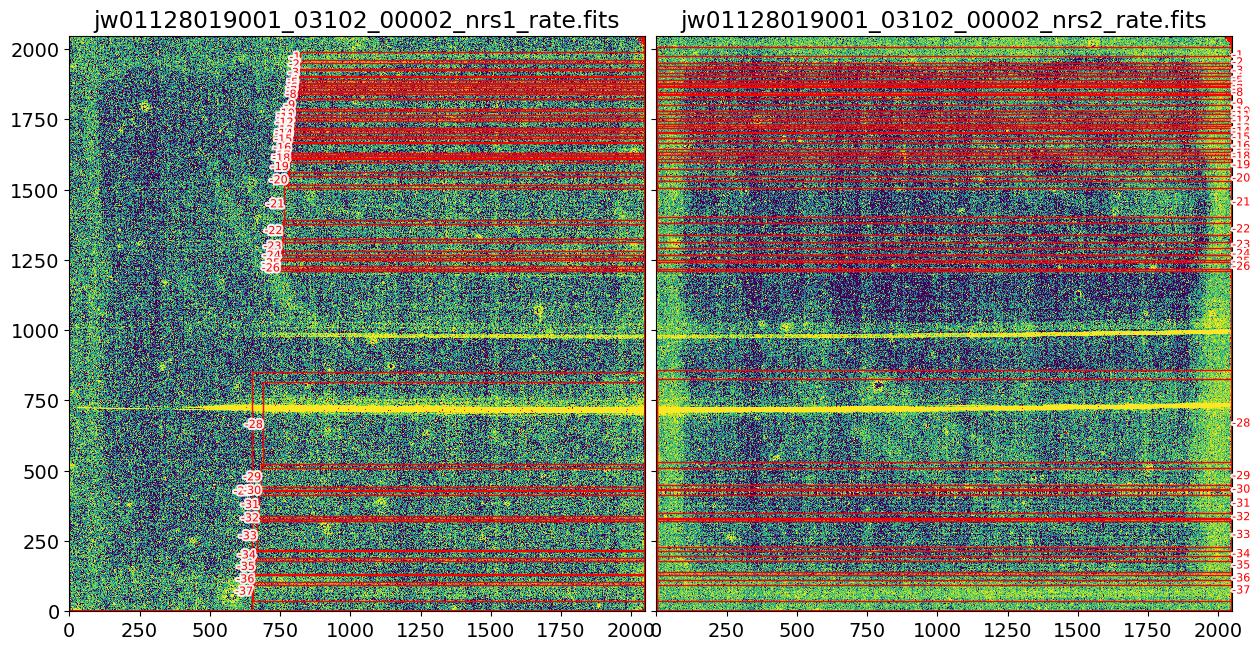

Error in callback <function flush_figures at 0x1655251c0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [74]:
for rate_file_nrs1 in rate_files_019_nrs1:
    rate_file_nrs2 = rate_file_nrs1.replace('nrs1', 'nrs2')
    show_MOS_rate_files([rate_file_nrs1, rate_file_nrs2], [s2d_model_spec2_nrs1, s2d_model_spec2_nrs2], save_plot=True)

In [30]:
s2d_files

['data/jw01128018001_03102_00002_nrs1_s2d.fits',
 'data/jw01128018001_03102_00003_nrs1_s2d.fits',
 'data/jw01128018001_03102_00004_nrs1_s2d.fits',
 'data/jw01128019001_03102_00002_nrs1_s2d.fits',
 'data/jw01128019001_03102_00002_nrs2_s2d.fits',
 'data/jw01128019001_03104_00001_nrs1_s2d.fits',
 'data/jw01128019001_03104_00001_nrs2_s2d.fits',
 'data/jw01128019001_03106_00001_nrs1_s2d.fits',
 'data/jw01128019001_03106_00001_nrs2_s2d.fits',
 'data/jw01128019001_03108_00001_nrs1_s2d.fits',
 'data/jw01128019001_0310a_00001_nrs1_s2d.fits',
 'data/jw01128019001_0310c_00001_nrs1_s2d.fits',
 'data/jw01128019001_0310e_00001_nrs1_s2d.fits',
 'data/jw01128019001_0310g_00001_nrs1_s2d.fits',
 'data/jw01128019001_0310i_00001_nrs1_s2d.fits']

In [31]:
s2d_file_spec2_nrs1 = s2d_files[3]
s2d_file_spec2_nrs1

'data/jw01128019001_03102_00002_nrs1_s2d.fits'

In [32]:
s2d_model_spec2_nrs1 = datamodels.open(s2d_file_spec2_nrs1)

In [70]:
s2d_file_spec2_nrs2 = s2d_file_spec2_nrs1.replace('_nrs1', '_nrs2')
s2d_model_spec2_nrs2 = datamodels.open(s2d_file_spec2_nrs2)

In [33]:
rate_file = rate_files[0]
rate_file

'com_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits'

jw01128018001_03102_00002_nrs1_rate.fits
[-0.003  0.     0.005  0.01   0.015  0.02   0.022]


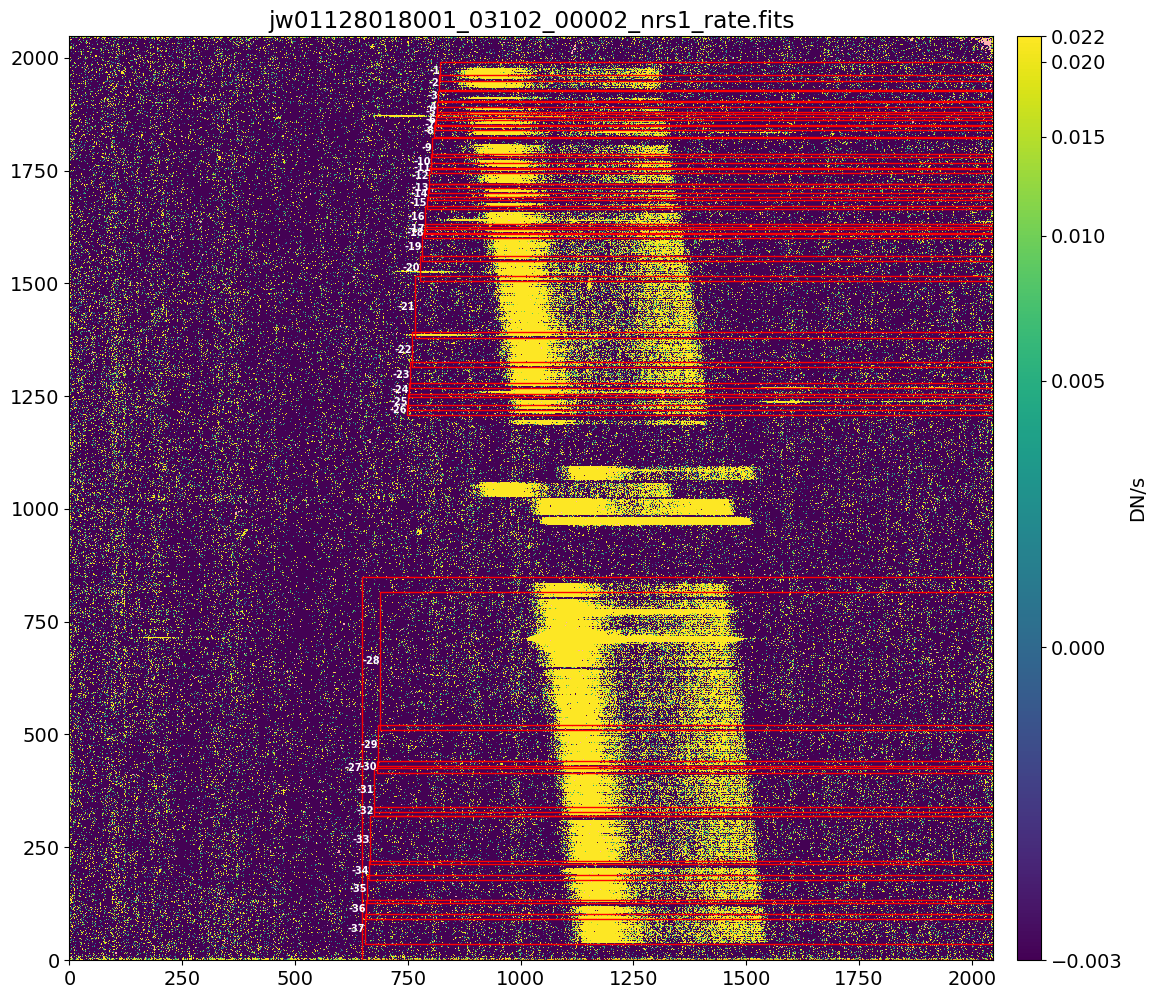

In [36]:
show_MOS_rate(rate_file, s2d_model_spec2_nrs1, save_plot=True)

In [29]:
rate_files = sorted(glob(os.path.join(rate_dir, '*_rate.fits')))
rate_files

['com_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128018001_03102_00002_nrs2_rate.fits',
 'com_mos_rate_files/jw01128018001_03102_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128018001_03102_00004_nrs1_rate.fits',
 'com_mos_rate_files/jw01128018001_03102_00004_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00003_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00003_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00004_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03102_00004_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00001_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00001_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00002_nrs1_rate.fits',
 'com_mos_rate_files/jw01128019001_03104_00002_nrs2_rate.fits',
 'com_mos_rate_files/jw01128019001_03104

In [52]:
rate_file
rate_model = datamodels.open(rate_file)
rate_model.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 829ef4bcd3b80d1d0e0514a03ca6dffffd97d44f567bd8fe8c640740181b056e
├─data (ndarray): shape=(2048, 2048), dtype=float32
├─dq (ndarray): shape=(2048, 2048), dtype=uint32
├─err (ndarray): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.10.1
│ ├─compress (bool): False
│ └─29 not shown
├─var_poisson (ndarray): shape=(2048, 2048), dtype=float32
└─var_rnoise (ndarray): shape=(2048, 2048), dtype=float32
Some nodes not shown.


In [53]:
rate_model.info(max_rows=99999)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension.BuiltinExtension
│     └─software (Software)
│       ├─name (str): asdf
│       └─version (str): 2.15.0
├─_fits_hash (str): 829ef4bcd3b80d1d0e0514a03ca6dffffd97d44f567bd8fe8c640740181b056e
├─data (ndarray): shape=(2048, 2048), dtype=float32
├─dq (ndarray): shape=(2048, 2048), dtype=uint32
├─err (ndarray): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict)
│ │ ├─name (str): NRS_FIELD1_MSA4
│ │ ├─position_angle (float): 300.2122393273995
│ │ └─pps_name (str): NRS_FIELD1_MSA4
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict)
│ │ ├─dark_sub (str): COMPLETE
│ │ ├─dq_init (str): COMPLETE
│ │ ├─gain_scale (str): COMPLETE
│ │ ├─group_scale (str): SKIPPED
│ │ ├─

In [54]:
rate_model.meta.instrument.grating

'PRISM'

In [55]:
for rate_file in rate_files:
    rate_model = datamodels.open(rate_file)
    print(rate_file, rate_model.meta.instrument.grating)

com_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits PRISM
com_mos_rate_files/jw01128018001_03102_00002_nrs2_rate.fits PRISM
com_mos_rate_files/jw01128018001_03102_00003_nrs1_rate.fits PRISM
com_mos_rate_files/jw01128018001_03102_00004_nrs1_rate.fits PRISM
com_mos_rate_files/jw01128018001_03102_00004_nrs2_rate.fits PRISM
com_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits G395H
com_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.fits G395H
com_mos_rate_files/jw01128019001_03102_00003_nrs1_rate.fits G395H
com_mos_rate_files/jw01128019001_03102_00003_nrs2_rate.fits G395H
com_mos_rate_files/jw01128019001_03102_00004_nrs1_rate.fits G395H
com_mos_rate_files/jw01128019001_03102_00004_nrs2_rate.fits G395H
com_mos_rate_files/jw01128019001_03104_00001_nrs1_rate.fits G235H
com_mos_rate_files/jw01128019001_03104_00001_nrs2_rate.fits G235H
com_mos_rate_files/jw01128019001_03104_00002_nrs1_rate.fits G235H
com_mos_rate_files/jw01128019001_03104_00002_nrs2_rate.fits G235H
com_mos_ra

In [57]:
for rate_file in rate_files:
    rate_model = datamodels.open(rate_file)
    print(rate_file, rate_model.meta.instrument.detector, rate_model.meta.instrument.grating, rate_model.meta.instrument.filter)

com_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00002_nrs2_rate.fits NRS2 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00003_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00004_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00004_nrs2_rate.fits NRS2 PRISM CLEAR
com_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00003_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00003_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00004_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00004_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03104_00001_nrs1_rate.fits NRS1 G235H F170LP
com_mos_rate_files/jw01128019001_03104_00001_nrs2_rate.fits NRS2 G235

In [60]:
ggsaa = os.path.basename(rate_file).split('_')[1]
ggsaa

'0310i'

In [63]:
gratings = {}
for rate_file in rate_files:
    rate_model = datamodels.open(rate_file)
    ggsaa = os.path.basename(rate_file).split('_')[1]
    if rate_model.meta.instrument.filter != 'OPAQUE':
        gratings[ggsaa] = rate_model.meta.instrument.grating + '/' + rate_model.meta.instrument.filter
    print(rate_file, rate_model.meta.instrument.detector, rate_model.meta.instrument.grating, rate_model.meta.instrument.filter)

com_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00002_nrs2_rate.fits NRS2 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00003_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00004_nrs1_rate.fits NRS1 PRISM CLEAR
com_mos_rate_files/jw01128018001_03102_00004_nrs2_rate.fits NRS2 PRISM CLEAR
com_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00003_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00003_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00004_nrs1_rate.fits NRS1 G395H F290LP
com_mos_rate_files/jw01128019001_03102_00004_nrs2_rate.fits NRS2 G395H F290LP
com_mos_rate_files/jw01128019001_03104_00001_nrs1_rate.fits NRS1 G235H F170LP
com_mos_rate_files/jw01128019001_03104_00001_nrs2_rate.fits NRS2 G235

In [67]:
for key in gratings.keys():
    print(key+' ', gratings[key])

03102  G395H/F290LP
03104  G235H/F170LP
03106  G140H/F100LP
03108  G140H/F070LP
0310a  G395M/F290LP
0310c  G235M/F170LP
0310e  G140M/F100LP
0310g  G140M/F070LP
0310i  PRISM/CLEAR


# Stage 1 `Detector1Pipeline`: `uncal` –> `rate`  <a id='stage1'></a> 

`calwebb_detector1`
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

In [ ]:
det1 = Detector1Pipeline()

In [ ]:
#det1.__dict__  # view entire contents
#det1.jump.__dict__  # view entire contents of jump step parameters

for key in 'expand_large_events min_sat_area min_jump_area expand_factor'.split():
    print(key.ljust(20), det1.jump.__dict__[key])

In [ ]:
det1.ramp_fit.maximum_cores

In [ ]:
det1.__dict__.keys()

In [ ]:
#det1.__dict__  # show all input parameter settings

### Input parameters
* [ramp fitting](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/arguments.html) (count rate slopes)  
* [jump step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html) (including rejections of cosmic rays, snowballs, etc.)

CEERS NIRSpec reduction parameters to improve jump step rejection of cosmic rays and snowballs  
https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt

In [ ]:
params_det1 = {}
params_det1['jump'] = {  # https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html
    'expand_large_events': True,
    'expand_factor':  3.0,  # default 2
    'min_sat_area':  15.0,  # default 1
    'min_jump_area': 15.0,  # default 5
    'maximum_cores': 'half',  # integer, 'quarter', 'half', 'all' -- run N times faster using N multiprocessors
}
params_det1['ramp_fit'] = {   # https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/arguments.html
    'maximum_cores': 'half',  # integer, 'quarter', 'half', 'all' -- run N times faster using N multiprocessors
}

params_det1

### Run `Detector1Pipeline`

In [ ]:
if run_pipeline:
    for uncal_file in sorted(uncal_files): 
        print('*' * 77)
        print(uncal_file)
        #print(os.path.basename(uncal_file))
        
        det1_result = Detector1Pipeline.call(
            uncal_file,
            save_results = True,
            output_dir = output_dir,
            steps = params_det1)

Note we run the pipeline using `.call()` instead of `.run()` to ensure we're using the latest default parameters from CRDS

https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html

In [ ]:
if 0:  # Don't do this. Use .call() instead of .run()
    det1.jump.expand_large_events = True
    det1.jump.min_sat_area  = 15.0
    det1.jump.min_jump_area = 15.0
    det1.jump.expand_factor = 3.0
    
    det1.save_results = True
    det1.output_dir = output_dir
    
    det1_result = det1.run(uncal_file)  

In [ ]:
#det1_result.__dict__  # view entire contents
#det1_result.meta.filename
#det1_result.data.shape

## Show rate file

In [ ]:
def show_MOS_rate(rate_file, save_plot=False, close_plot=False, integration=None, cmap=cmap, title_prefix=''):    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    
    #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
    #print(norm.vmin, norm.vmax)
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    

    if title_prefix:
        title = title_prefix + '  '
    else:
        title = ''
    title += os.path.basename(rate_file)
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    plt.title(title)
    print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

## The adjusted jump step parameters effectively reject cosmic rays and snowballs

In [ ]:
#rate_file = os.path.basename(uncal_file).replace('_uncal.fits', '_rate.fits')
#rate_file = os.path.join(output_dir, rate_file)

In [ ]:
#output_dir = 'reprocess'
rate_files = glob(os.path.join(output_dir, '*_rate.fits'))
rate_file = rate_files[0]
rate_file

In [ ]:
show_MOS_rate(rate_file, title_prefix='REPROCESSED')

In [ ]:
# Alternative quick plot
if 0:
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.imshow(data, origin='lower', vmin=-0.01, vmax=0.02, interpolation='nearest')

## The default jump step parameters don't work as well

Compare to the data product in MAST generated using the pipeline with default parameters

In [ ]:
#download_dir = 'data'
MAST_rate_file = download_jwst_files([rate_file], download_dir)[0]

In [ ]:
show_MOS_rate(MAST_rate_file, title_prefix='MAST')

# Stage 2 `Spec2Pipeline`: `rate` –> `cal`, `s2d`, `x1d`  <a id='stage2'></a> 

`calwebb_spec2`
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Run on association files defining science and background slitlets for each of 3 nod exposures  
3 exposures x 2 detectors = 6 association files  

`Spec2Pipeline` takes 7 minutes on a MacBook Pro laptop (with reference files already downloaded)

### First retrieve the MSA METAFILE 

that defines all the shutters (slitlets) and sources including where they are, and which shutters have science data vs. background:

In [ ]:
rate_files = glob(os.path.join(output_dir, '*_rate.fits'))

if run_pipeline:
    for rate_file in rate_files:
        try:
            # Download MSA metafile
            msa_file = fits.getval(rate_file, 'MSAMETFL')
            download_jwst_files([msa_file], output_dir)
        except:
            pass

Downloading URL https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:jwst/product/jw02736007001_01_msa.fits to reprocess/jw02736007001_01_msa.fits ... [Done]

In [ ]:
hdu_list = fits.open(rate_file)
msa_metafile = hdu_list[0].header['MSAMETFL']
msa_metafile = os.path.join(output_dir, msa_metafile)
hdu_list = fits.open(msa_metafile)
hdu_list.info()

### Also retrieve the association files

In [40]:
#spec2_asn_files = glob(os.path.join(asn_dir, '*.json'))
spec2_asn_files = glob(os.path.join(output_dir, '*.json'))
#spec2_asn_files = select_files(spec2_asn_files, ['o007', 'spec2'])
spec2_asn_files = sorted(spec2_asn_files)
spec2_asn_files

[]

In [ ]:
    obs_table = Observations.query_criteria(obs_collection = 'JWST', 
                                            proposal_id = 2736,  # program number 2736: ERO SMACS0723
                                            instrument_name = 'NIRSPEC/MSA',
                                            filters = 'g395m',
                                            dataproduct_type = 'spectrum',
                                           )
    
    products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.


In [45]:
asn_data_products = Observations.filter_products(
    products_list, 
    productType = 'INFO', 
    productSubGroupDescription = 'ASN',  # UNCAL, RATE, RATEINTS, CAL, I2D, X1D, S2D, ASN
    #type = 'D', # 'S': simple output from spec2 / image2;  'D': combined multiple exposures from spec3
)
#asn_data_products

asn_files = unique(asn_data_products, keys='productFilename')
asn_filenames = asn_files['productFilename']
spec_asn_files = select_files(asn_filenames, ['o019', 'spec'])
#spec_asn_files
spec_asn_files = download_jwst_files(spec_asn_files, output_dir)
#spec2_asn_files = select_files(spec_asn_files, ['spec2'])

In [ ]:
# Download from MAST if you haven't already
if len(spec2_asn_files) == 0:

    asn_data_products = Observations.filter_products(
        products_list, 
        productType = 'INFO', 
        productSubGroupDescription = 'ASN',  # UNCAL, RATE, RATEINTS, CAL, I2D, X1D, S2D, ASN
        #type = 'D', # 'S': simple output from spec2 / image2;  'D': combined multiple exposures from spec3
    )
    #asn_data_products
    
    asn_files = unique(asn_data_products, keys='productFilename')
    asn_filenames = asn_files['productFilename']
    spec_asn_files = select_files(asn_filenames, ['o007', 'spec'])
    #print(spec_asn_files)
    spec_asn_files = download_jwst_files(spec_asn_files, output_dir)
    spec2_asn_files = select_files(spec_asn_files, ['spec2'])

In [46]:
spec2_asn_files = select_files(spec_asn_files, ['spec2'])
spec2_asn_files

['reprocess/jw01128-o019_20240112t213210_spec2_00006_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00012_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00018_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00024_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00030_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00036_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00039_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00042_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00045_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00048_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00051_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec2_00054_asn.json']

In [47]:
for asn_file in spec2_asn_files:
    print('-' * 33)
    print(os.path.basename(asn_file))
    with open(asn_file, 'r') as f_obj:
        asn_file_data = json.load(f_obj)

    for member in asn_file_data['products'][0]['members']:
        print(member['expname'], member['exptype'])

---------------------------------
jw01128-o019_20240112t213210_spec2_00006_asn.json
jw01128019001_0310i_00001_nrs1_rate.fits science
jw01128019001_0310i_00002_nrs1_rate.fits background
jw01128019001_0310i_00003_nrs1_rate.fits background
---------------------------------
jw01128-o019_20240112t213210_spec2_00012_asn.json
jw01128019001_0310g_00001_nrs1_rate.fits science
jw01128019001_0310g_00002_nrs1_rate.fits background
jw01128019001_0310g_00003_nrs1_rate.fits background
---------------------------------
jw01128-o019_20240112t213210_spec2_00018_asn.json
jw01128019001_0310e_00001_nrs1_rate.fits science
jw01128019001_0310e_00002_nrs1_rate.fits background
jw01128019001_0310e_00003_nrs1_rate.fits background
---------------------------------
jw01128-o019_20240112t213210_spec2_00024_asn.json
jw01128019001_0310c_00001_nrs1_rate.fits science
jw01128019001_0310c_00002_nrs1_rate.fits background
jw01128019001_0310c_00003_nrs1_rate.fits background
---------------------------------
jw01128-o019_20240

In [48]:
spec3_asn_files = select_files(spec_asn_files, ['spec3'])
spec3_asn_files

['reprocess/jw01128-o019_20240112t213210_spec3_00007_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec3_00008_asn.json',
 'reprocess/jw01128-o019_20240112t213210_spec3_00009_asn.json']

In [50]:
for asn_file in spec3_asn_files:
    print('-' * 33)
    print(os.path.basename(asn_file))
    with open(asn_file, 'r') as f_obj:
        asn_file_data = json.load(f_obj)

    for member in asn_file_data['products'][0]['members']:
        if member['exptype'] == 'science':
            print(member['expname'], member['exptype'])

---------------------------------
jw01128-o019_20240112t213210_spec3_00007_asn.json
jw01128019001_03106_00001_nrs1_cal.fits science
jw01128019001_03106_00001_nrs2_cal.fits science
---------------------------------
jw01128-o019_20240112t213210_spec3_00008_asn.json
jw01128019001_03104_00001_nrs1_cal.fits science
jw01128019001_03104_00001_nrs2_cal.fits science
---------------------------------
jw01128-o019_20240112t213210_spec3_00009_asn.json
jw01128019001_03102_00002_nrs1_cal.fits science
jw01128019001_03102_00002_nrs2_cal.fits science


In [ ]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

In [ ]:
# association files need to be in same directory as rate files

### Set up `Spec2Pipeline`

In [ ]:
spec2pipe = Spec2Pipeline()

In [ ]:
spec2pipe.__dict__.keys()

In [ ]:
spec2pipe.steps['resample_spec']['weight_type']

### Input parameters
* [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/arguments.html)
    * `weight_type`:
        * `ivm` pixel-based inverse read noise works best to reject outliers
        * `exptime` improves SNR, especially for bright objects (and will become the new default)

see https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats

In [ ]:
params_spec2 = {}

# This is the current default, but that will change, so set explicitly:
params_spec2['resample_spec'] = {  
    'weight_type': 'ivm'  # pixel-based inverse read noise (vs. 'exptime' single value exposure time)
}

params_spec2

### Run `Spec2Pipeline`

In [ ]:
if run_pipeline:
    for asn_file in spec2_asn_files:
        spec2_result = Spec2Pipeline.call(
            asn_file,
            save_results = True,
            output_dir = output_dir,
            steps = params_spec2
        )

In [ ]:
# Output cleared

# Stage 3 `Spec3Pipeline`: combine exposures –> `s2d`, `x1d` for each target <a id='stage3'></a> 

`calwebb_spec3`
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

In [ ]:
spec3pipe = Spec3Pipeline()

In [ ]:
spec3pipe.__dict__.keys()

In [ ]:
#spec3pipe.__dict__  # show all input values

In [ ]:
asn_files = glob(os.path.join(output_dir, '*.json'))
spec3_asn_file = select_files(asn_files, ['o007', 'spec3'])  # Observation 7 (Observation 8 is similar; could do separately)
spec3_asn_file

In [ ]:
# Alternatively, you could extract that info from the data products
#spec3_cal_asn_file = cal_model[0].meta.asn.table_name
#spec2_cal_asn_file = cal_model.exposures[0].meta.asn.table_name

In [ ]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

In [ ]:
#asn_data

In [ ]:
# Create a subdirectory for the many output files (several for each extracted source)
spec3_output_dir = os.path.join(output_dir, 'spec3')
os.makedirs(spec3_output_dir, exist_ok=True)
spec3_output_dir

In [ ]:
params_spec3 = {}
params_spec3['outlier_detection'] = {'skip' : False} # Flag outlier bad pixels and cosmic rays in DQ array of each input image
params_spec3['resample_spec']     = {'weight_type' : 'ivm'}  # pixel-based inverse read noise (vs. 'exptime' single value exposure time)
params_spec3['extract_1d']        = {'use_source_posn' : 'True'} # extraction rows based on expected source position
params_spec3

In [ ]:
spec3_asn_file

### Run `Spec3Pipeline`

In [ ]:
if run_pipeline:
    spec3_result = Spec3Pipeline.call(
        spec3_asn_file,
        save_results = True,
        output_dir = spec3_output_dir,
        steps = params_spec3
    )

In [ ]:
# Output cleared

## Show spectrum result

In [ ]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w',
                     ystart=None, ystop=None): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    #ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    if ystart:
        for y in ystart, ystop:
            #ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
            ax2d.axhline(y, c='m', lw=0.5)
        ax2d.set_yticks([0, ystart, ystop, ny-1])
        if 1:
            extract_width = 8
            ystart0 = ny//2 - extract_width/2
            ystop0  = ny//2 + extract_width/2 -1
            for y in ystart0, ystop0:
                ax2d.axhline(y, c='0.50', lw=0.5, ls='--', dashes=(10,10))
    else:
        ax2d.set_yticks([0, (ny-1)/2., ny-1])
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    #ax1d.set_ylim(-2e-6, 2e-5)
    #ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    ax1d.set_title('X1D Flux (Jy)')
    plt.xticks(xtick_pos, xtick_labels)
    plt.xlabel('wavelength (microns)');

In [ ]:
source_id = 6355
s2d_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
#spec3_output_dir = os.path.join(output_dir, 'spec3')
s2d_file = os.path.join(spec3_output_dir, s2d_file)
print(s2d_file)
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # show all contents
#s2d_data = s2d_model.data + 0

In [ ]:
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

In [ ]:
show_MOS_spectrum(s2d_model, x1d_model, source_id)

# `Extract1dStep`: Adjust 2D –> 1D extraction

[extract1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) • 
[Extract1dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_1d.Extract1dStep.html) • 
[Description](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html#extraction-for-2d-slit-data) • 
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data)

OPTIONAL to modify which rows in S2D (2D spectrum) are used for extraction to X1D (1D spectrum). 
Useful for source off-center in slit in the cross-dispersion direction.

(Note the X1D file does not save information about which rows were used. This information is printed as output during execution but not saved.)

Define extraction region in `.json` file, then run `Extract1dStep`  
Output file will end in `_extract1dstep.fits`

`extract_width` takes priority over `ystart` and `ystop` for the extraction width,   
but `ystart` and `ystop` will still be used to define the centering of the extraction region in the cross-dispersion direction.

All of these values are zero-indexed integers. The start and stop limits are inclusive.

The default EXTRACT1D reference file is found in CRDS. The user can download this file from https://jwst-crds.stsci.edu, modify the contents, and then use this modified file in `Extract1dStep` by specifying this modified reference file with the `override_extract1d` option


### See also

* [Adjusting the extraction region](https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_General/nrs_recenter_extraction_workaround.ipynb)
* [MOSViz interactive extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [Optimal extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html)
* [msaexp optimal extraction](https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/drizzle.py#L869C19-L869C19)


### Either download the default `extract1d` parameter reference file from CRDS...

In [ ]:
#default_extract1d_json_file = 'jwst_nirspec_extract1d_0003.json'  # could find this on https://jwst-crds.stsci.edu

In [ ]:
s2d_header = fits.open(s2d_file)[0].header
s2d_file

In [ ]:
crds_context = crds.get_default_context()
crds_context

In [ ]:
# Download the reference file, or find it in your cache
default_extract1d_json_file = crds.getreferences(s2d_header, reftypes=['extract1d'], context=crds_context, observatory='jwst')['extract1d']
default_extract1d_json_file

In [ ]:
with open(default_extract1d_json_file) as f_obj:
    extract1d_json_data = json.load(f_obj)

In [ ]:
#extract1d_json_data
JSON(extract1d_json_data, expanded=True)

### ...or create the JSON file from scratch

In [ ]:
extract1d_json_data = {'reftype':'EXTRACT1D', 'instrument':'NIRSPEC', 'telescope':'JWST', 'exp_type':'NRS_MSASPEC'}
extract1d_json_data['apertures'] = [{'id':'ANY', 'region_type':'target', 'independent_var':'pixel', 'bkg_order':0, 'dispaxis':1,
                                   'extract_width':8,  # Best not to adjust this. Slit losses are calibrated to this extraction width.
                                   }]

if run_pipeline:
    json_object = json.dumps(extract1d_json_data, indent=4)
    default_extract1d_json_file = 'jwst_nirspec_extract1d_default.json'
    with open(default_extract1d_json_file, "w") as outfile:
        outfile.write(json_object)
    
    JSON(extract1d_json_data, expanded=True)

### Define the extraction region

In [ ]:
#ystart = 21  # You decide which rows to use for the extraction region
#ycenter = 15  # for most sources with standard 3-slitlet nods
ycenter = 25
extract_width = extract1d_json_data['apertures'][0]['extract_width']  # use default extraction width
ystart = ycenter - extract_width // 2
ystop = ystart + extract_width - 1
extract1d_json_data['apertures'][0]['ystart'] = ystart
extract1d_json_data['apertures'][0]['ystop']  = ystop
print(ystart, ystop)

In [ ]:
extract1d_json_data['apertures'][0]

In [ ]:
if run_pipeline:
    json_object = json.dumps(extract1d_json_data, indent=4)
    custom_extract1d_json_file = 'jwst_nirspec_extract1d_custom.json'
    with open(custom_extract1d_json_file, "w") as outfile:
        outfile.write(json_object)

In [ ]:
if run_pipeline:
    extract1d_result = Extract1dStep.call(s2d_file,
                                use_source_posn=False, 
                                apply_apcorr=False,
                                override_extract1d = custom_extract1d_json_file,
                                save_results=True, output_dir=spec3_output_dir)

# Output file ends in _extract1dstep (not _x1d); okay to save in same output directory
# jw02736-o007_s06355_nirspec_f290lp-g395m_extract1dstep.fits

In [ ]:
extract_x1d_file = s2d_file.replace('s2d', 'extract1dstep')
print(extract_x1d_file)
extract1d_result = datamodels.open(extract_x1d_file)

### Show the result

In [ ]:
#show_MOS_spectrum(s2d_model, x1d_model, source_id)
show_MOS_spectrum(s2d_model, extract1d_result, ystart=ystart, ystop=ystop)

### Compare spectra from MAST, pipeline reprocessing, and updated 1D extraction

In [ ]:
s2d_file

In [ ]:
x1d_file = s2d_file.replace('s2d', 'x1d')
s2d_model = datamodels.open(s2d_file)
x1d_model = datamodels.open(x1d_file)
x1d_wave = x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux = x1d_model.spec[0].spec_table.FLUX

In [ ]:
extract1d_file = s2d_file.replace('s2d', 'extract1dstep')
extract1d_model = datamodels.open(extract1d_file)
extract1d_wave = extract1d_model.spec[0].spec_table.WAVELENGTH
extract1d_flux = extract1d_model.spec[0].spec_table.FLUX

In [ ]:
MAST_s2d_file = download_jwst_files([s2d_file], download_dir)[0]
MAST_x1d_file = download_jwst_files([x1d_file], download_dir)[0]
MAST_s2d_model = datamodels.open(MAST_s2d_file)
MAST_x1d_model = datamodels.open(MAST_x1d_file)
x1d_wave_MAST = MAST_x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux_MAST = MAST_x1d_model.spec[0].spec_table.FLUX

In [ ]:
num_waves = len(x1d_wave)
wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
eps = 1e-7
#major_tick_interval = 0.5
major_tick_interval = 0.2
xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
xticks = np.arange(xtick_min, wave_max, major_tick_interval)
#xticks = np.append(xticks, [5.2])
num_waves = len(x1d_wave)
xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
xtick_labels = ['%.1f' % xtick for xtick in xticks]

### Compare MAST (default pipeline) vs. pipeline reprocessing

In [ ]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST,  lw=1, c='c', label='MAST')
ax1d.step(np.arange(num_waves), x1d_flux,       lw=1, c='k', label='reprocessed', alpha=0.7)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax1d.set_title('X1D Flux (Jy)')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();

### Compare updated 1D extraction

In [ ]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST,  lw=1, c='c', label='MAST',  alpha=0.5)
ax1d.step(np.arange(num_waves), x1d_flux,       lw=1, c='k', label='reprocessed',  alpha=0.5)
ax1d.step(np.arange(num_waves), extract1d_flux, lw=1, c='r', label='re-extracted', alpha=1)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax1d.set_title('X1D Flux (Jy)')

ax2d.set_yticks([ystart, ystop])
for y in ystart, ystop:
    ax2d.axhline(y, c='r', alpha=1, lw=1, ls='-')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();

# Authors

Dan Coe (dcoe@stsci.edu) including many contributions from others on the NIRSpec team, including Elena Manjavacas, Peter Zeidler, Kayli Glidic, Melanie Clarke, James Muzerrole, Nikolay Nikolov, and Alaina Henry who designed the ERO NIRSpec observations